In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from collections import Counter
from sklearn.metrics import silhouette_score, davies_bouldin_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import LabelEncoder
plt.style.use("fivethirtyeight")
from tqdm.notebook import tqdm


In [8]:
!pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable


In [10]:
df = pd.read_csv("Dataset-Tugas.csv")
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [12]:
df['class'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: class, dtype: int64

In [18]:
df['class'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Kolom `class` memiliki 3 target yaitu `Iris-setosa`, `Iris-versicolor`, dan `Iris-virginica` dengan masing-masing target berjumlah 50. Karena masih dalam bentuk object, maka kita lakukan drop kolom `class`.

In [22]:
df.drop(['class'], axis=1, inplace=True)
df.head()

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


# EDA

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [27]:
df.isna().sum()

sepal length    0
sepal width     0
petal length    0
petal width     0
dtype: int64

In [29]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width,150.0,3.054000,0.433594,2.0,2.8,3.00,3.3,4.4
petal length,150.0,3.758667,1.764420,1.0,1.6,4.35,5.1,6.9
petal width,150.0,1.198667,0.763161,0.1,0.3,1.30,1.8,2.5


In [33]:
df.shape

(150, 4)

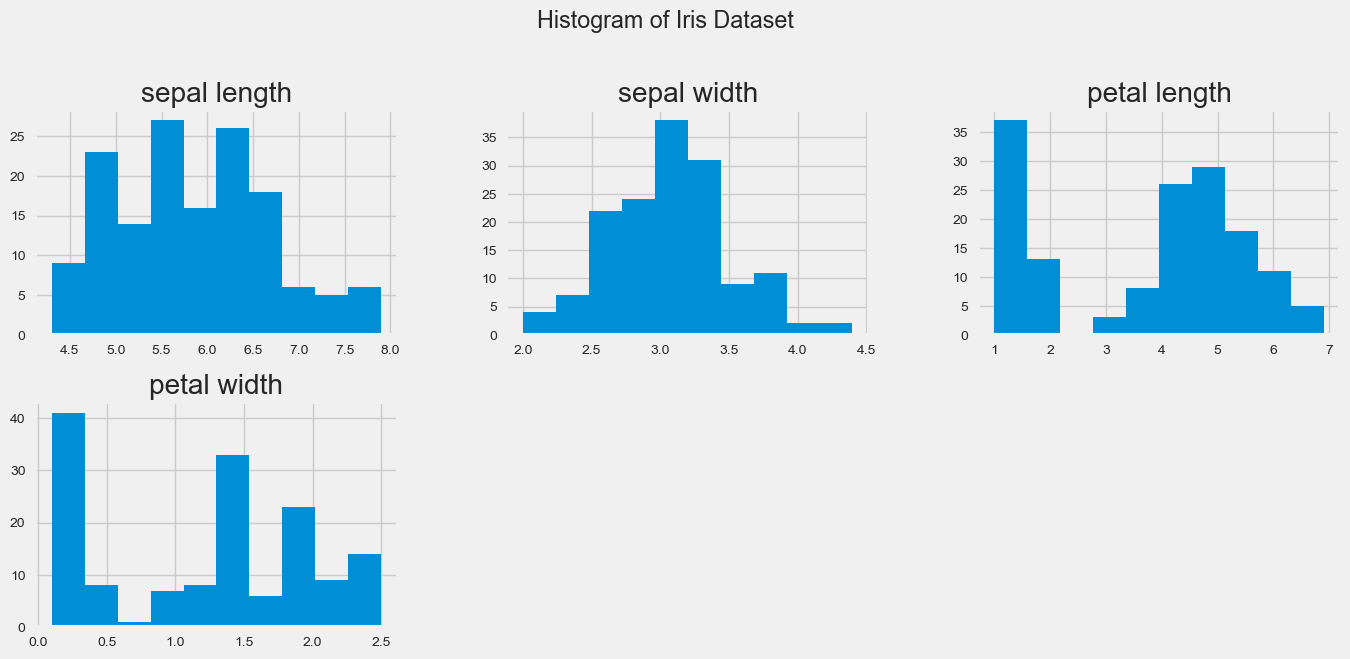

In [35]:
def plot_histograms(data):
    data.hist(bins=10, figsize=(15,10), layout=(3,3))
    plt.suptitle("Histogram of Iris Dataset")
    plt.show()

plot_histograms(df)

Berdasarkan histogram, dapat dilihat bahwa setiap kolo tidak berdistribusi normal. Oleh karena itu, kita harus melakukan normalisasi data agar skala datany sama atau datanya berdistribusi normal.

In [38]:
def count_outliers_iqr(data):
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((data < lower_bound) | (data > upper_bound)).sum()

outlier_counts = {}

for col in df.select_dtypes(include=['int64', 'float64']).columns:
    outlier_counts[col] = count_outliers_iqr(df[col])

outliers_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Column', 'Outliers Count'])

outliers_counts_df

,Column,Outliers Count
0,sepal length,0
1,sepal width,4
2,petal length,0
3,petal width,0


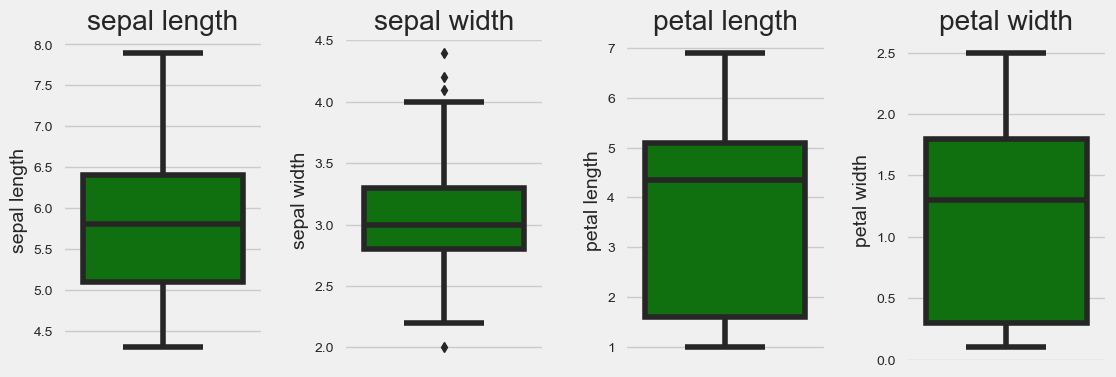

In [40]:
def box_plot(df):
    variabel = df.select_dtypes(exclude='object').columns
    
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    for i, var in enumerate(variabel):
        sns.boxplot(y=var, data=df, color='green', ax=axes[i])
        axes[i].set_title(var)
        
    plt.show()
    
box_plot(df)

Jika dilihat pada boxplot, dalam kolom `sepal width` terdapat oulier yang berjumlah 4.

# DATA PREPROCESSING

In [144]:
scaler = MinMaxScaler()

# Fit transform
X_scaled = scaler.fit_transform(df)


# MODELLING

### Dengan K-Means

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

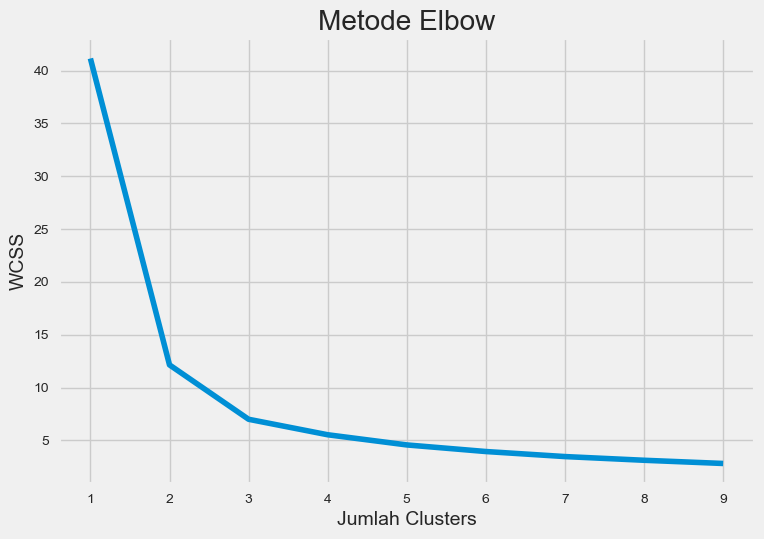

In [48]:
wcss = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,10), wcss)
plt.title("Metode Elbow")
plt.xlabel("Jumlah Clusters")
plt.ylabel("WCSS")
plt.show()

In [146]:
#menjalankan K-Means Clustering ke dataset
model1 = KMeans(n_clusters=2, init='k-means++', random_state=42)
y_pred1 = model1.fit_predict(X_scaled)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


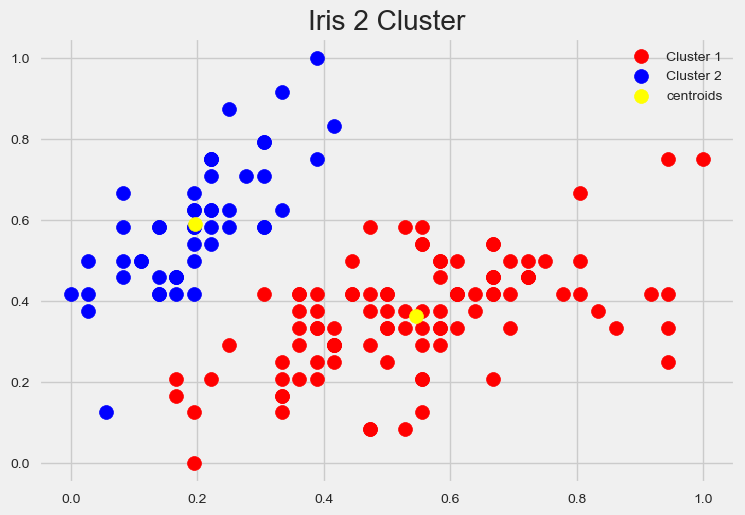

In [150]:
plt.scatter(X_scaled[y_pred1 == 0, 0], X_scaled[y_pred1 == 0, 1],
           s = 100, c = 'red', label='Cluster 1')

plt.scatter(X_scaled[y_pred1 == 1, 0], X_scaled[y_pred1 == 1, 1],
           s = 100, c = 'blue', label='Cluster 2')

plt.scatter(model1.cluster_centers_[:, 0], model1.cluster_centers_[:, 1],
           s = 100, c = 'yellow', label = 'centroids')

plt.title("Iris 2 Cluster")
plt.legend()
plt.show()

In [56]:
df['Label_K-Means2'] = model1.labels_
df.head()

,sepal length,sepal width,petal length,petal width,Label_K-Means2
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


In [58]:
df['Label_K-Means2'].value_counts()

0    100
1     50
Name: Label_K-Means2, dtype: int64

In [164]:
#menjalankan K-Means Clustering ke dataset
model2 = KMeans(n_clusters= 3, init='k-means++', random_state=42)
y_pred2 = model2.fit_predict(X_scaled)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


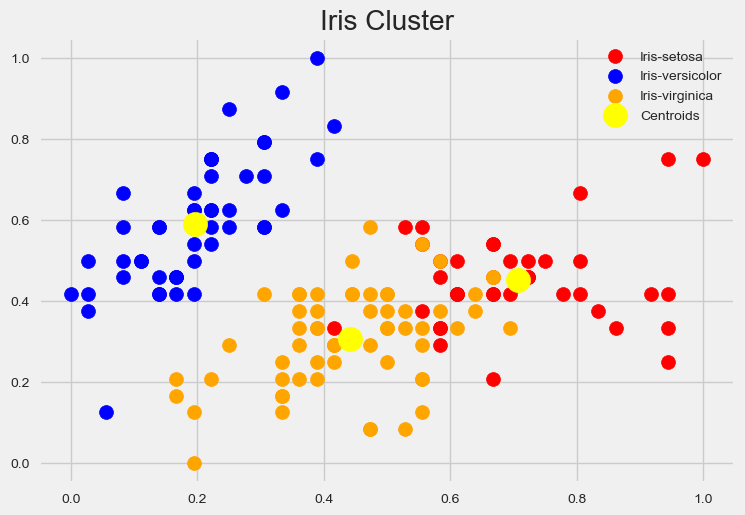

In [168]:
plt.scatter(X_scaled[y_pred2 == 0, 0], X_scaled[y_pred2 == 0, 1],
            s = 100, c = 'red', label = 'Iris-setosa')
plt.scatter(X_scaled[y_pred2 == 1, 0], X_scaled[y_pred2 == 1, 1],
            s = 100, c = 'blue', label = 'Iris-versicolor')
plt.scatter(X_scaled[y_pred2 == 2, 0], X_scaled[y_pred2 == 2, 1],
            s = 100, c = 'orange', label = 'Iris-virginica')

plt.scatter(model2.cluster_centers_[:, 0], model2.cluster_centers_[:, 1], 
            s = 300, c = 'yellow', label = 'Centroids')

plt.title('Iris Cluster')
plt.legend()
plt.show()

In [76]:
df['Label_K-Means2'] = model1.labels_
df.head()

,sepal length,sepal width,petal length,petal width,Label_K-Means2
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


In [82]:
df['Label_K-Means2'].value_counts()

2    61
1    50
0    39
Name: Label_K-Means2, dtype: int64

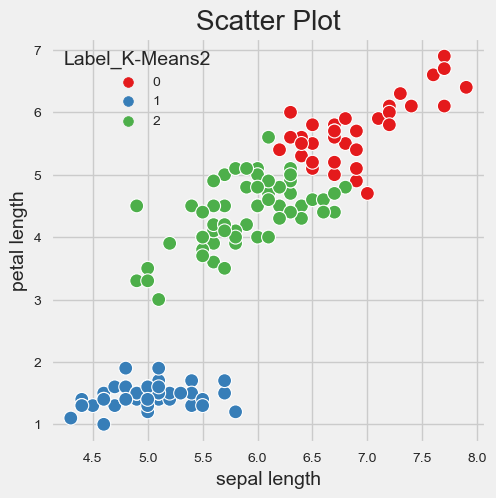

In [86]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x = 'sepal length', y = 'petal length', hue = 'Label_K-Means2', data = df, palette = 'Set1', s=100);
plt.title("Scatter Plot")
plt.show()

# DBSCAN

In [91]:
db = DBSCAN(eps=0.4, min_samples=5)
db.fit(X_scaled)

y_pred_db = db.labels_

In [93]:
y_pred_db

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [95]:
df['Label_DB-Scan'] = db.labels_
df.head()

,sepal length,sepal width,petal length,petal width,Label_K-Means2,Label_DB-Scan
0,5.1,3.5,1.4,0.2,1,0
1,4.9,3.0,1.4,0.2,1,0
2,4.7,3.2,1.3,0.2,1,0
3,4.6,3.1,1.5,0.2,1,0
4,5.0,3.6,1.4,0.2,1,0


In [99]:
df['Label_DB-Scan'].value_counts()

1    100
0     50
Name: Label_DB-Scan, dtype: int64

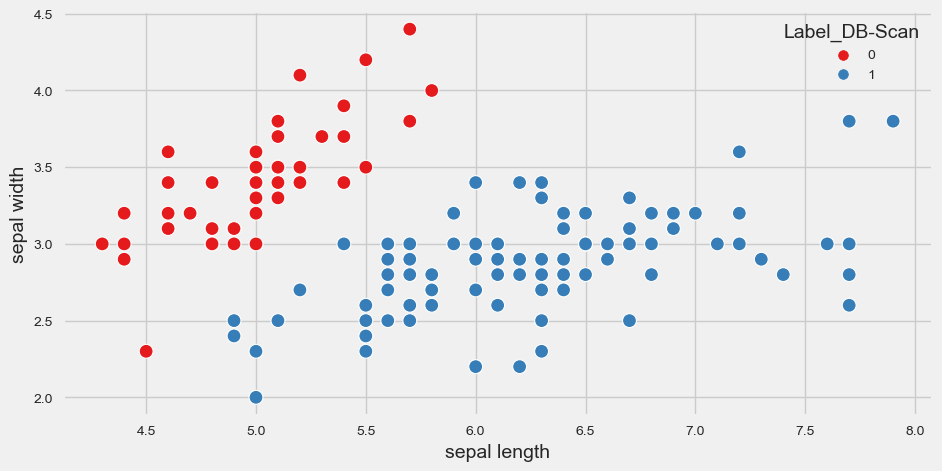

In [101]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x = 'sepal length', y = 'sepal width', hue = 'Label_DB-Scan', data = df, palette = 'Set1', s=100);

# Evaluation

In [170]:
e_km2 = silhouette_score(X_scaled, y_pred1)
dbi_km2 = davies_bouldin_score(X_scaled, y_pred1)

print('Silhouette Score K-Means 2 Cluster:', e_km2)
print('Davies-Bouldin Index K-Means 2 Cluster:', dbi_km2)

Silhouette Score K-Means 2 Cluster: 0.6337644250459633
Davies-Bouldin Index K-Means 2 Cluster: 0.5344179305375514


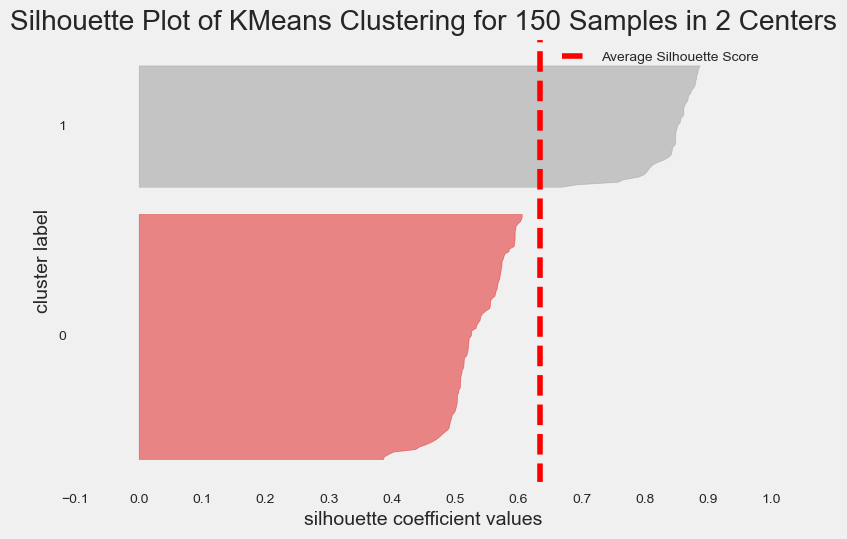

In [172]:
silhouette_viz = SilhouetteVisualizer(model1)
silhouette_viz.fit(X_scaled)
plt.grid(False)
silhouette_viz.show()
plt.show()

In [174]:
e_km = silhouette_score(X_scaled, y_pred2)
dbi_km = davies_bouldin_score(X_scaled, y_pred2)

print('Silhouette Score K-Means 3 Cluster:', e_km)
print('Davies-Bouldin Index K-Means 3 Cluster 3:', dbi_km)

Silhouette Score K-Means 3 Cluster: 0.7702345243106153
Davies-Bouldin Index K-Means 3 Cluster 3: 0.34556610301952445


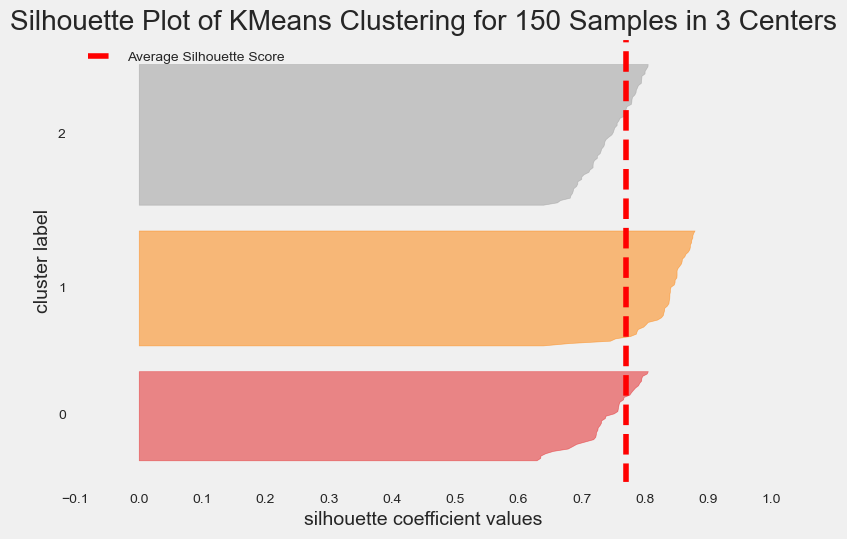

In [176]:
silhouette_viz = SilhouetteVisualizer(model2)
silhouette_viz.fit(X_scaled)
plt.grid(False)
silhouette_viz.show()
plt.show()

In [180]:
e_db = silhouette_score(X_scaled, y_pred_db)
dbi_db = davies_bouldin_score(X_scaled, y_pred_db)

print('Silhouette Score DBSCAN:', e_db)
print('Davies-Bouldin Index DBSCAN:', dbi_db)

Silhouette Score DBSCAN: 0.6337644250459633
Davies-Bouldin Index DBSCAN: 0.5344179305375514
